In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelo Específico
from sklearn.ensemble import RandomForestClassifier

# Métricas
from sklearn.metrics import (classification_report, roc_auc_score, RocCurveDisplay,
                             ConfusionMatrixDisplay, precision_score, recall_score,
                             f1_score, confusion_matrix, precision_recall_curve)

# Balanceo
from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.tree import export_graphviz
import graphviz


In [2]:
# CONFIGURACIÓN
SEED = 42
DATA_DIR = 'Data/' # Ajusta si tus archivos están en otra carpeta

# Umbral de corte inicial (Random Forest suele calibrar bien en 0.5, pero lo dejamos variable)
UMBRAL_CORTE = 0.5

pd.set_option('display.max_columns', None)

# Configuración Visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# Archivos

MODELOCL = 'CL'
MODELOAR = 'DOMAR'
MODELOPE = 'DOMPE'
MODELOCO = 'DOMCO'
MODELOIN = 'INTER'


In [4]:
# Parámetros base para Random Forest
PARAMS_ESTATICOS = {
    'GENERAL': {
        'class_weight': 'balanced',
        'max_depth': 20,
        'min_samples_leaf': 4,
        'min_samples_split': 2,
        'n_estimators': 500
    },
    'CL':     {
        'class_weight': 'balanced',
        'max_depth': 12,
        'min_samples_leaf': 4,
        'min_samples_split': 2,
        'n_estimators': 400
    },
    'PE':     {
        'class_weight': 'balanced',
        'max_depth': 20,
        'min_samples_leaf': 1,
        'min_samples_split': 2,
        'n_estimators': 500
    },
    'CO':     {
        'class_weight': 'balanced',
        'max_depth': 12,
        'min_samples_leaf': 4,
        'min_samples_split': 2,
        'n_estimators': 500
    },
    'AR':     {
        'class_weight': 'balanced',
        'max_depth': 20,
        'min_samples_leaf': 1,
        'min_samples_split': 2,
        'n_estimators': 400
    }
}
PARAMS_OPTIMIZADOS = {
    'GENERAL': {'class_weight': 'balanced', 'n_estimators': 500, 'max_depth': 22, 'min_samples_split': 15, 'min_samples_leaf': 10},
    'CL': {'class_weight': 'balanced', 'n_estimators': 800, 'max_depth': 19, 'min_samples_split': 15, 'min_samples_leaf': 2},
    'PE': {'class_weight': 'balanced', 'n_estimators': 200, 'max_depth': 22, 'min_samples_split': 20, 'min_samples_leaf': 11},
    'CO': {'class_weight': 'balanced', 'n_estimators': 200, 'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 6},
    'AR': {'class_weight': 'balanced', 'n_estimators': 400, 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 1}
}

In [5]:
def matriz_correlacion(pack_modelo, X, feature_names=None, top_n=37):
    """
    Genera la matriz de correlación de las variables más importantes y muestra
    explícitamente los nombres de las variables incluidas.
    Retorna: (corr_dataframe, lista_de_variables_incluidas)
    """
    model = pack_modelo['model']

    # 1. Obtener importancias (RandomForest)
    importancias = getattr(model, "feature_importances_", None)
    if importancias is None:
        raise ValueError("El modelo no tiene 'feature_importances_'. Asegúrate de pasar un RandomForest entrenado.")

    # 2. Crear DataFrame de features
    if isinstance(X, pd.DataFrame):
        df_X = X.copy()
    else:
        if feature_names is None:
            feature_names = [f"f_{i}" for i in range(X.shape[1])]
        df_X = pd.DataFrame(X, columns=feature_names)

    # 3. Selección top_n (o todas si top_n es None)
    if top_n is None or top_n >= df_X.shape[1]:
        cols_top = list(df_X.columns)
    else:
        # manejar posible desajuste de tamaño
        n_feats = min(len(importancias), df_X.shape[1])
        importancias = importancias[:n_feats]
        indices_top = np.argsort(importancias)[::-1][:top_n]
        cols_top = [df_X.columns[i] for i in indices_top]

    df_top = df_X[cols_top]

    # 4. Calcular Correlación (Pearson)
    corr = df_top.corr()

    # 5. Graficar
    plt.figure(figsize=(20, 12))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, square=True, cbar_kws={'shrink': .8}, annot_kws={'size':8})
    plt.title(f"Matriz de Correlación (Top {len(cols_top)} Variables)")
    plt.tight_layout()
    plt.show()

    return corr


In [6]:
def entrenar_rf_visual(X_train, X_test, y_train, y_test, nombre_modelo, params):

    print(f"PROCESANDO RANDOM FOREST: {nombre_modelo}")
    print(f"{'='*60}")

    # 1. Separar parámetros del modelo de los nuestros
    rf_params = {k: v for k, v in params.items() if k != 'usar_smote' and k != 'threshold'}

    # 2. Aplicar SMOTE (Balanceo)
    if params.get('usar_smote', False):
        print(f"-> Aplicando SMOTE (Balanceo Sintético)...")
        smote = SMOTE(random_state=SEED)
        X_train_final, y_train_final = smote.fit_resample(X_train, y_train)
    else:
        X_train_final, y_train_final = X_train, y_train

    # 3. Entrenar Modelo
    print(f"-> Entrenando bosque con {rf_params.get('n_estimators', '??')} árboles...")
    model = RandomForestClassifier(**rf_params)
    model.fit(X_train_final, y_train_final)

    # 4. Predicciones (Probabilidades)
    probs_test = model.predict_proba(X_test)[:, 1]

    # USAR UMBRAL FIJO (sin optimización automática)
    mejor_umbral = params.get('threshold', UMBRAL_CORTE)
    preds = (probs_test >= mejor_umbral).astype(int)

    # 5. Métricas y Reportes
    auc = roc_auc_score(y_test, probs_test)

    print(f"\nREPORTE FINAL ({nombre_modelo})")
    print(classification_report(y_test, preds, target_names=['Ocio', 'Trabajo']))
    print(f"AUC-ROC Score: {auc:.4f}")

    # 6. Gráficos
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # Matriz de Confusión
    cm = confusion_matrix(y_test, preds)
    ConfusionMatrixDisplay(cm, display_labels=['Ocio', 'Trabajo']).plot(ax=ax[0], cmap='Greens')
    ax[0].set_title(f"Matriz de Confusión (Corte: {mejor_umbral:.2f})")
    ax[0].grid(False)

    # Curva ROC
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax[1], name=nombre_modelo)
    ax[1].plot([0, 1], [0, 1], 'k--')
    ax[1].set_title("Curva ROC")

    plt.tight_layout()
    plt.show()

    return {'model': model}

In [7]:
def graficar_importancia_rf(pack_modelo, feature_names, top_n=20):
    """
    Muestra las top_n variables con un color por barra (colormap 'viridis')
    usando la API actual de Matplotlib para evitar el MatplotlibDeprecationWarning.
    """
    model = pack_modelo['model']
    importancias = model.feature_importances_

    df_imp = pd.DataFrame({
        'Variable': feature_names,
        'Importancia': importancias
    }).sort_values('Importancia', ascending=False).head(top_n)

    vals = df_imp['Importancia'].values
    if vals.max() - vals.min() > 0:
        norm = (vals - vals.min()) / (vals.max() - vals.min())
    else:
        norm = np.zeros_like(vals)

    # Uso de la API recomendada: plt.get_cmap
    cmap = plt.get_cmap('viridis')
    colors = cmap(norm)

    fig, ax = plt.subplots(figsize=(16, 10))
    y_pos = np.arange(len(df_imp))
    bars = ax.barh(y_pos, df_imp['Importancia'].values, color=colors)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(df_imp['Variable'].values)
    ax.invert_yaxis()
    ax.set_xlabel("Importancia Relativa (0 a 1)")
    ax.set_title("Importancia de Variables (Random Forest - Gini)")

    # Intentar usar bar_label (más limpio). Si no existe, usar texto manual.
    try:
        ax.bar_label(bars, fmt='%.4f', padding=6)
    except Exception:
        max_width = df_imp['Importancia'].max() if len(df_imp) else 1.0
        x_offset = max_width * 0.01  # pequeño espacio a la derecha de la barra
        for bar in bars:
            w = bar.get_width()
            ax.text(w + x_offset, bar.get_y() + bar.get_height() / 2, f'{w:.3f}',
                    va='center', ha='left', fontsize=9)

    plt.tight_layout()
    plt.show()


PROCESANDO RANDOM FOREST: RF_General
-> Entrenando bosque con 500 árboles...

REPORTE FINAL (RF_General)
              precision    recall  f1-score   support

        Ocio       0.85      0.81      0.83      4551
     Trabajo       0.51      0.58      0.54      1540

    accuracy                           0.75      6091
   macro avg       0.68      0.69      0.69      6091
weighted avg       0.76      0.75      0.76      6091

AUC-ROC Score: 0.7886


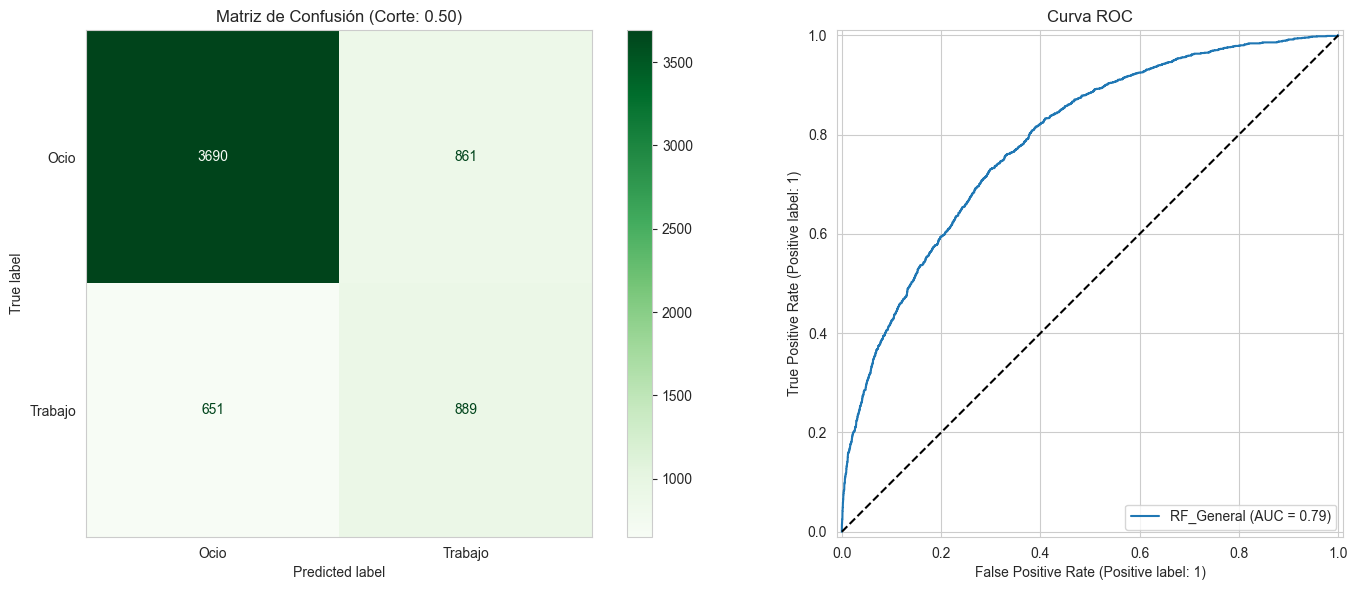

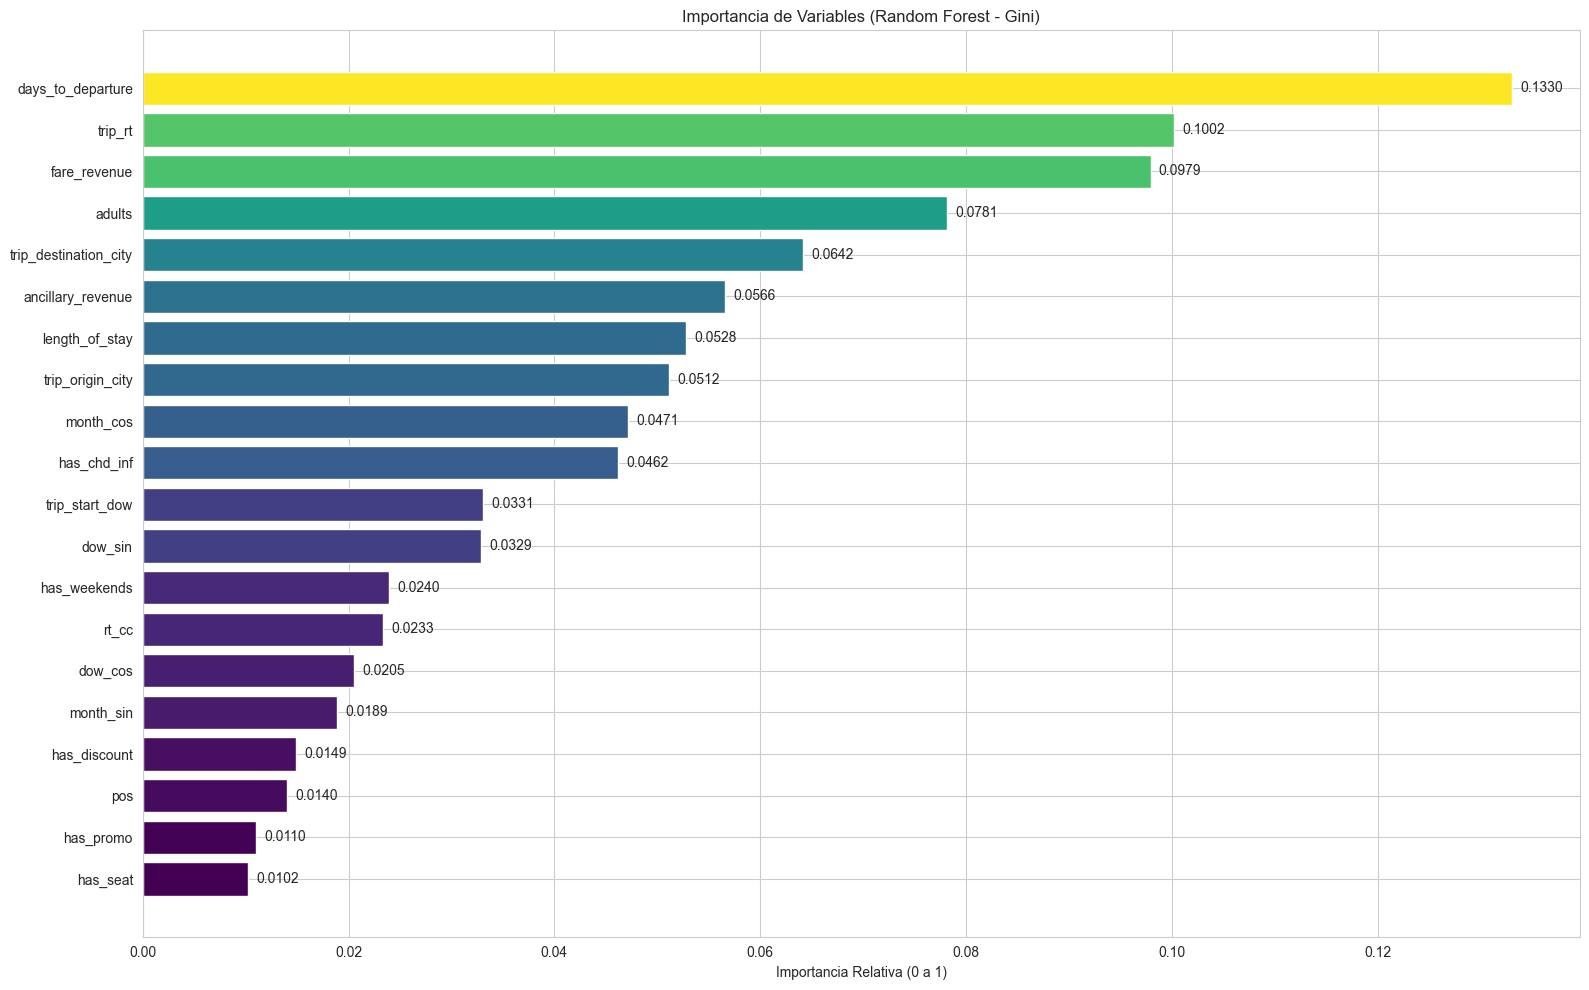

In [8]:
modelo = 'General'

X_train = pd.read_parquet(f'{DATA_DIR}X_train_{modelo}_encoded.parquet')# .drop(['days_to_departure'], axis=1)
X_test = pd.read_parquet(f'{DATA_DIR}X_test_{modelo}_encoded.parquet')# .drop(['days_to_departure'], axis=1)
y_train = pd.read_pickle(f'{DATA_DIR}y_train_{modelo}.pkl')
y_test = pd.read_pickle(f'{DATA_DIR}y_test_{modelo}.pkl')

# Entrenar
pack_rf_general = entrenar_rf_visual(
    X_train, X_test, y_train, y_test, 'RF_General', PARAMS_ESTATICOS['GENERAL']
)

# Graficar Importancia
graficar_importancia_rf(pack_rf_general, X_train.columns)

Cargando Chile...
PROCESANDO RANDOM FOREST: RF_Chile
-> Entrenando bosque con 400 árboles...

REPORTE FINAL (RF_Chile)
              precision    recall  f1-score   support

        Ocio       0.85      0.80      0.83       596
     Trabajo       0.66      0.74      0.70       317

    accuracy                           0.78       913
   macro avg       0.76      0.77      0.76       913
weighted avg       0.79      0.78      0.78       913

AUC-ROC Score: 0.8510


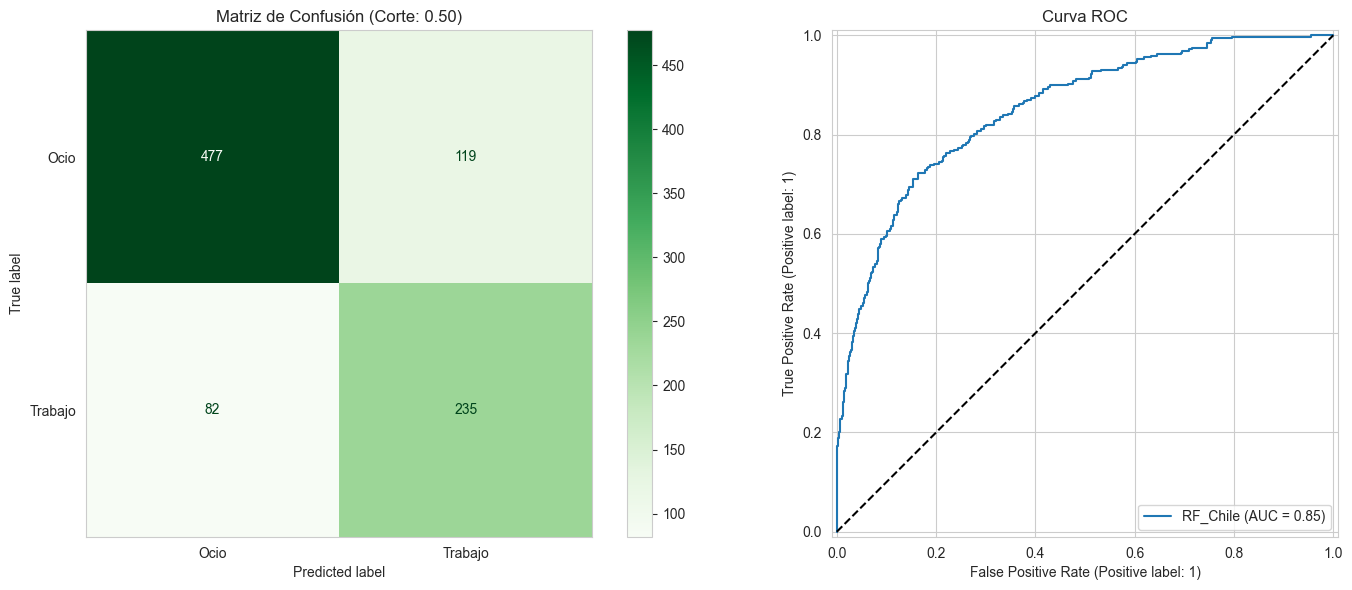

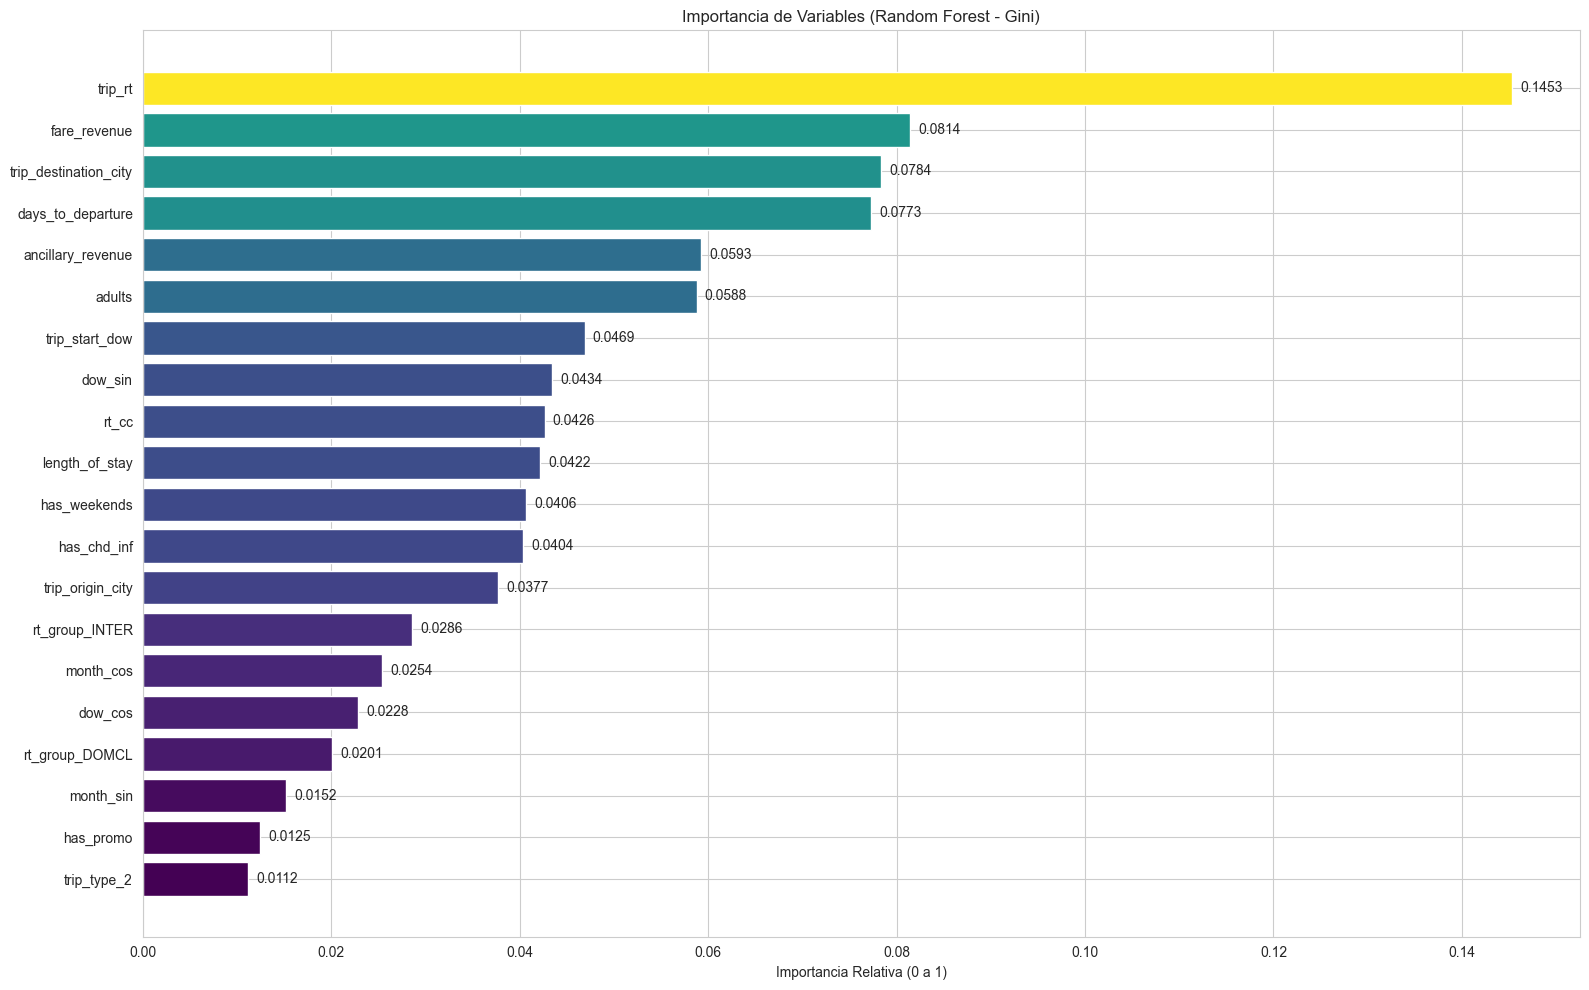

In [9]:
print("Cargando Chile...")
# Asegúrate que el nombre del archivo coincida con lo generado en el 01
X_train = pd.read_parquet(f'{DATA_DIR}X_train_{MODELOCL}_encoded.parquet')# .drop(['trip_rt'], axis=1)
X_test = pd.read_parquet(f'{DATA_DIR}X_test_{MODELOCL}_encoded.parquet')# .drop(['trip_rt'], axis=1)
y_train = pd.read_pickle(f'{DATA_DIR}y_train_{MODELOCL}.pkl')
y_test = pd.read_pickle(f'{DATA_DIR}y_test_{MODELOCL}.pkl')



pack_rf_cl = entrenar_rf_visual(
    X_train, X_test, y_train, y_test,
    "RF_Chile", PARAMS_ESTATICOS['CL']
)

graficar_importancia_rf(pack_rf_cl, X_train.columns)


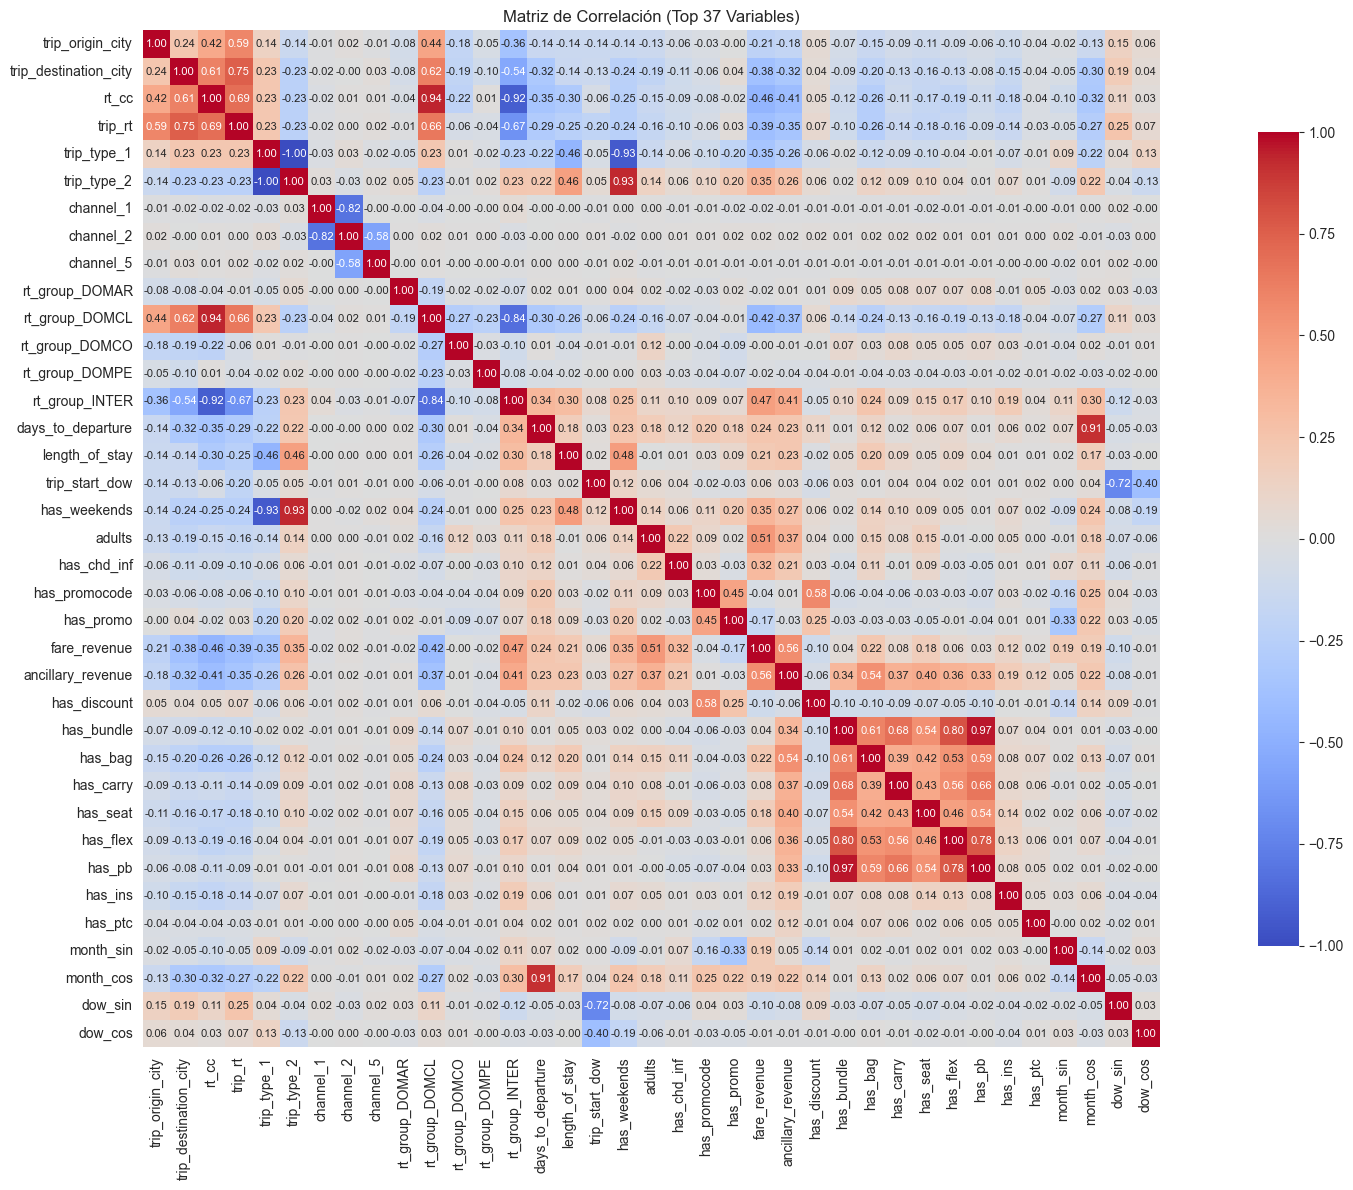

,trip_origin_city,trip_destination_city,rt_cc,trip_rt,trip_type_1,trip_type_2,channel_1,channel_2,channel_5,rt_group_DOMAR,rt_group_DOMCL,rt_group_DOMCO,rt_group_DOMPE,rt_group_INTER,days_to_departure,length_of_stay,trip_start_dow,has_weekends,adults,has_chd_inf,has_promocode,has_promo,fare_revenue,ancillary_revenue,has_discount,has_bundle,has_bag,has_carry,has_seat,has_flex,has_pb,has_ins,has_ptc,month_sin,month_cos,dow_sin,dow_cos
trip_origin_city,1.000000,0.241716,0.416777,0.591291,0.137764,-0.137764,-0.014127,0.017304,-0.009988,-0.084733,0.440796,-0.184571,-0.047720,-0.362789,-0.141258,-0.140097,-0.135996,-0.137267,-0.125291,-0.058293,-0.034559,-0.002713,-0.214175,-0.180725,0.051155,-0.072044,-0.145307,-0.091660,-0.110300,-0.093416,-0.064188,-0.095383,-0.038191,-0.024815,-0.128638,0.147920,0.059161
trip_destination_city,0.241716,1.000000,0.612234,0.752300,0.228525,-0.228525,-0.015413,-0.003898,0.028545,-0.077555,0.622679,-0.188577,-0.095584,-0.543660,-0.319532,-0.143342,-0.129838,-0.236346,-0.190678,-0.106611,-0.056073,0.044566,-0.377156,-0.322553,0.042684,-0.087154,-0.204673,-0.130205,-0.161832,-0.133363,-0.084688,-0.152108,-0.037132,-0.049915,-0.301091,0.189154,0.044411
rt_cc,0.416777,0.612234,1.000000,0.693267,0.228602,-0.228602,-0.024107,0.013822,0.010153,-0.044789,0.938055,-0.217157,0.014799,-0.921344,-0.350507,-0.298734,-0.059669,-0.248228,-0.147512,-0.094557,-0.079484,-0.024237,-0.461190,-0.412841,0.048645,-0.116623,-0.261858,-0.114691,-0.169438,-0.188766,-0.113688,-0.182194,-0.038108,-0.095968,-0.316401,0.112738,0.026509
trip_rt,0.591291,0.752300,0.693267,1.000000,0.229255,-0.229255,-0.019976,0.004945,0.019683,-0.014707,0.655530,-0.059206,-0.041924,-0.667569,-0.289438,-0.248616,-0.197882,-0.242877,-0.164804,-0.103689,-0.061607,0.026789,-0.391396,-0.349334,0.070681,-0.102954,-0.259407,-0.142197,-0.184810,-0.162062,-0.094444,-0.142894,-0.032765,-0.050811,-0.268873,0.249205,0.065786
trip_type_1,0.137764,0.228525,0.228602,0.229255,1.000000,-1.000000,-0.026746,0.032762,-0.018910,-0.053002,0.232186,0.012535,-0.023785,-0.233139,-0.218777,-0.461566,-0.050796,-0.933043,-0.137735,-0.055515,-0.103502,-0.199520,-0.345558,-0.260724,-0.061092,-0.015569,-0.119278,-0.089739,-0.102145,-0.044782,-0.006736,-0.068636,-0.009922,0.086874,-0.222233,0.041253,0.132043
trip_type_2,-0.137764,-0.228525,-0.228602,-0.229255,-1.000000,1.000000,0.026746,-0.032762,0.018910,0.053002,-0.232186,-0.012535,0.023785,0.233139,0.218777,0.461566,0.050796,0.933043,0.137735,0.055515,0.103502,0.199520,0.345558,0.260724,0.061092,0.015569,0.119278,0.089739,0.102145,0.044782,0.006736,0.068636,0.009922,-0.086874,0.222233,-0.041253,-0.132043
channel_1,-0.014127,-0.015413,-0.024107,-0.019976,-0.026746,0.026746,1.000000,-0.816385,-0.000387,-0.002868,-0.035794,-0.004086,-0.003503,0.042435,-0.000132,-0.004009,-0.010924,0.004775,0.003549,-0.008163,-0.007812,-0.017476,-0.016166,-0.012401,-0.013080,-0.008764,-0.014374,-0.012843,-0.016122,-0.010984,-0.009073,-0.005811,-0.001737,-0.012724,0.002597,0.018928,-0.003127
channel_2,0.017304,-0.003898,0.013822,0.004945,0.032762,-0.032762,-0.816385,1.000000,-0.577192,0.003513,0.022979,0.005005,0.004291,-0.029381,-0.002201,0.000905,0.013381,-0.015604,0.001908,0.010000,0.009569,0.021406,0.019801,0.015190,0.016022,0.010735,0.017607,0.015732,0.019748,0.013454,0.011114,0.007118,0.002128,0.022493,-0.010510,-0.028255,0.004945
channel_5,-0.009988,0.028545,0.010153,0.019683,-0.018910,0.018910,-0.000387,-0.577192,1.000000,-0.002027,0.010823,-0.002889,-0.002477,-0.009129,0.003998,0.004101,-0.007723,0.020267,-0.008321,-0.005772,-0.005523,-0.012356,-0.011429,-0.008767,-0.009248,-0.006196,-0.010163,-0.009080,-0.011399,-0.007766,-0.006415,-0.004108,-0.001228,-0.020957,0.014527,0.022162,-0.004142
rt_group_DOMAR,-0.084733,-0.077555,-0.044789,-0.014707,-0.053002,0.053002,-0.002868,0.003513,-0.002027,1.000000,-0.187330,-0.021386,-0.018334,-0.067578,0.015500,0.013669,0.000467,0.043516,0.018572,-0.020835,-0.025776,0.017388,-0.015315,0.012171,0.006130,

In [10]:
matriz_correlacion(pack_rf_general, X_train)

Reporte del Árbol de Decisión:
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       596
           1       0.00      0.00      0.00       317

    accuracy                           0.65       913
   macro avg       0.33      0.50      0.39       913
weighted avg       0.43      0.65      0.51       913



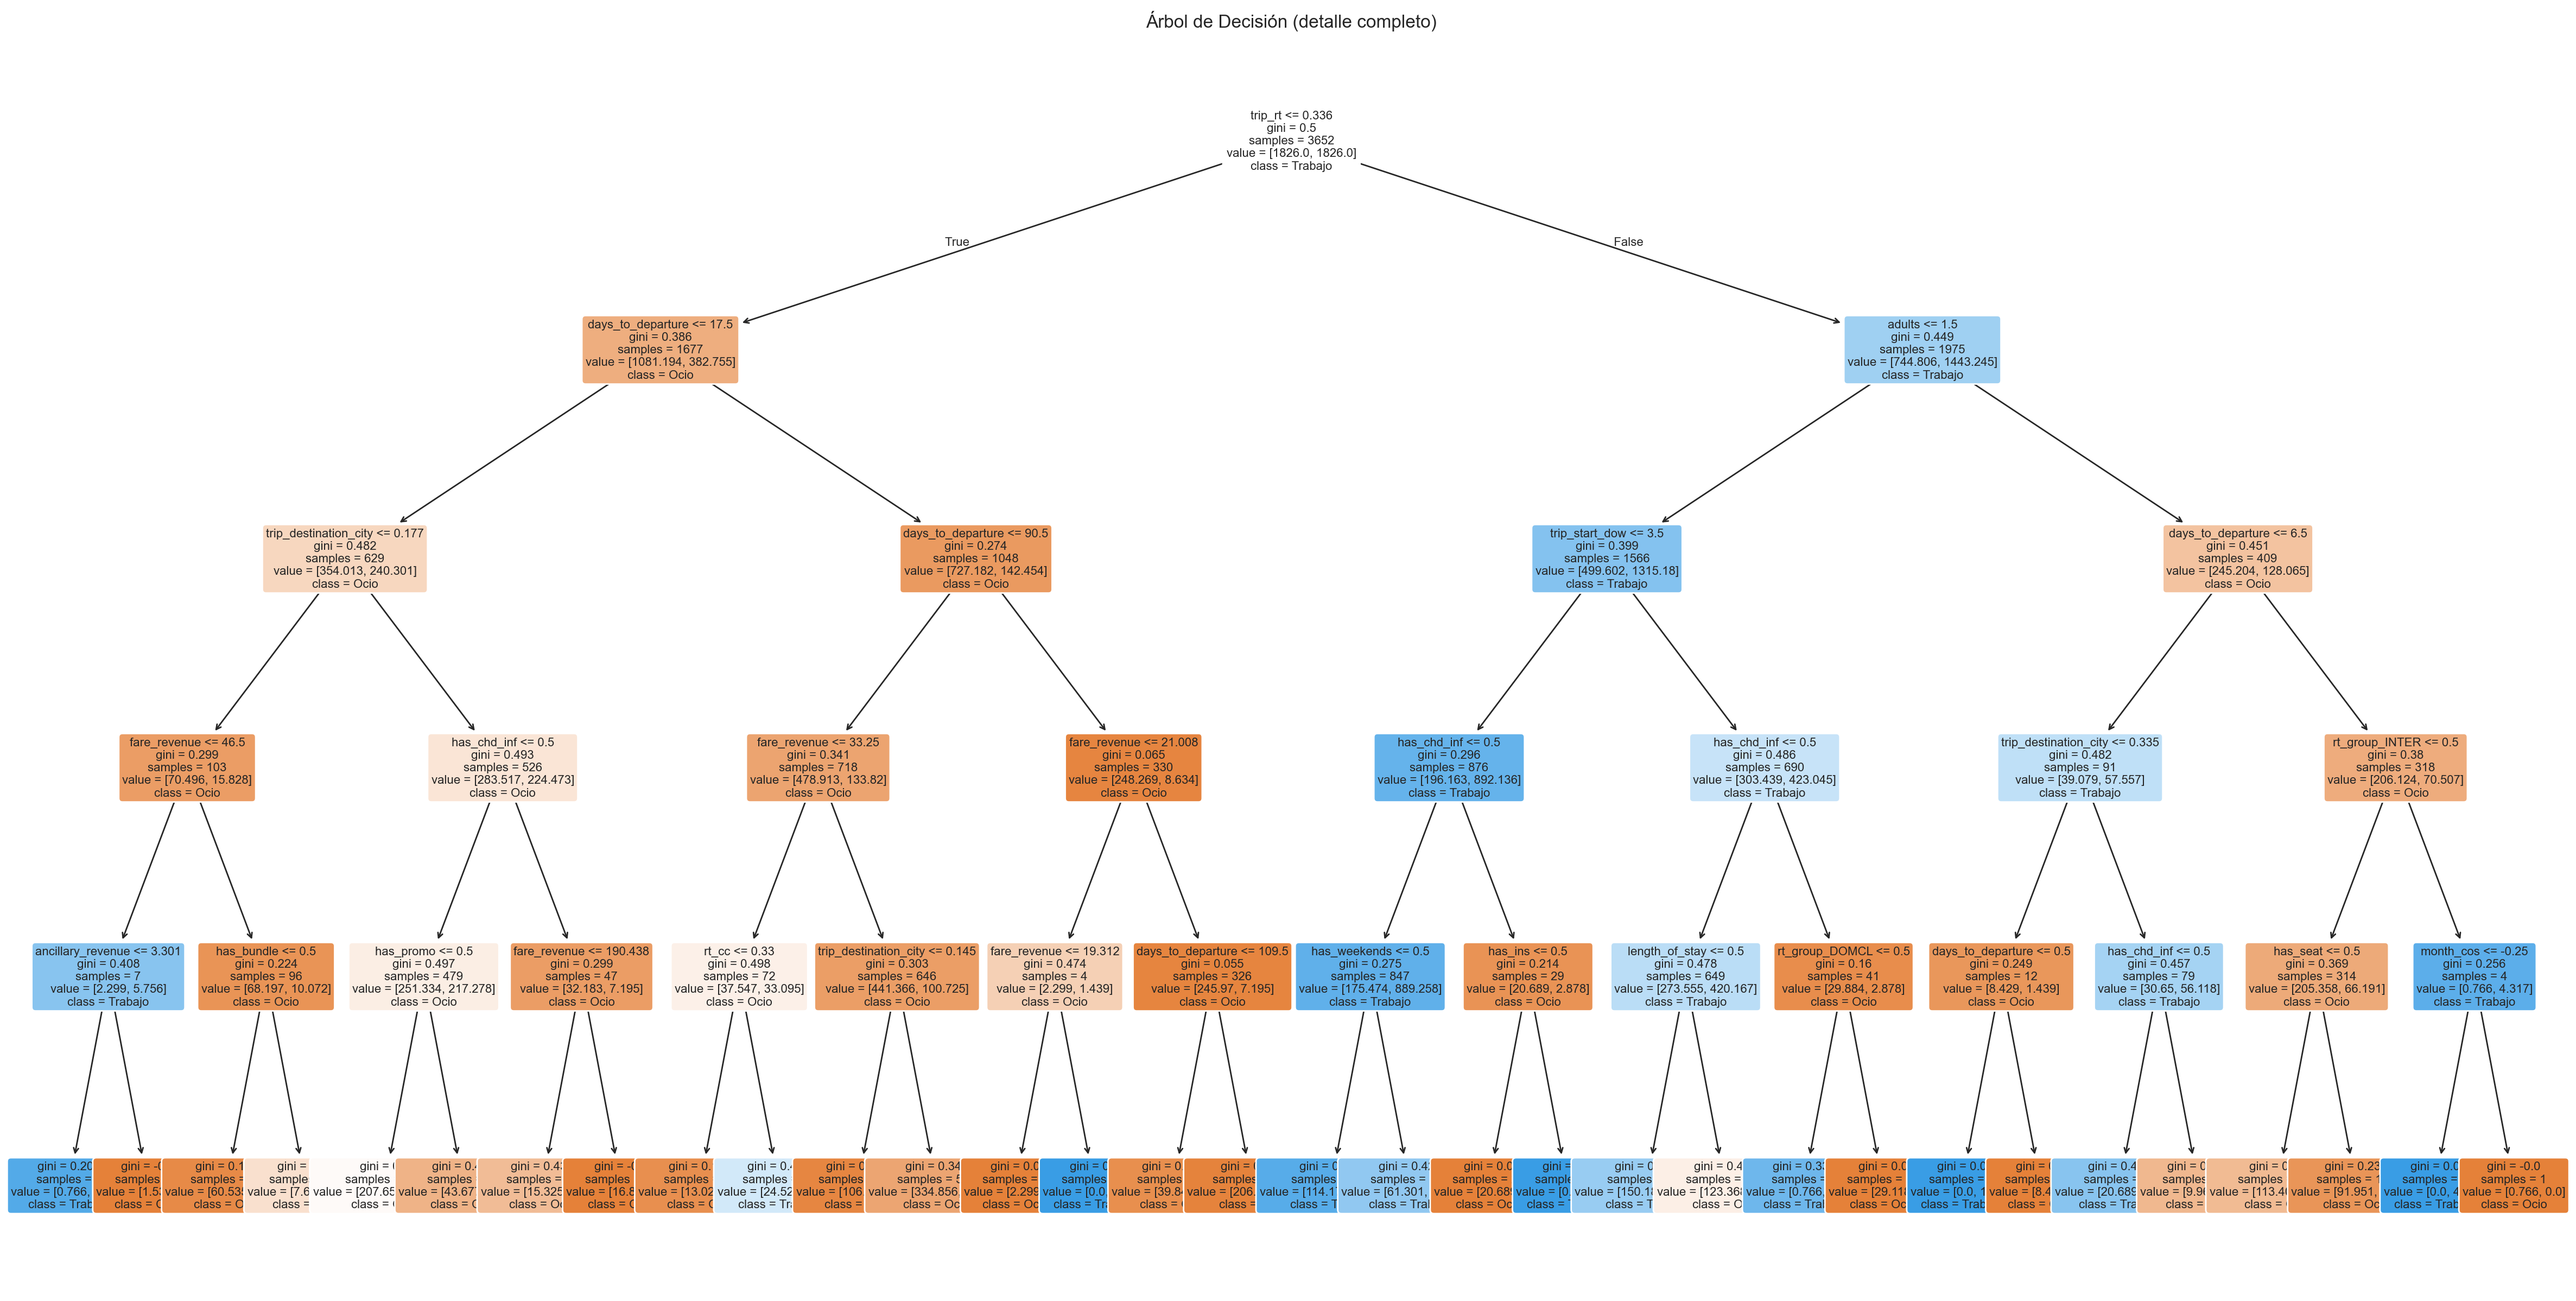

In [11]:
# 2. Definir el Modelo (Decision Tree)
model_dt = DecisionTreeClassifier(
    max_depth=5,
    class_weight='balanced',
    criterion='gini',
    random_state=SEED
)

# 3. Entrenar
model_dt.fit(X_train, y_train)

# 5. Evaluar
y_pred_proba_dt = model_dt.predict_proba(X_test)[:, 1]
y_pred_final_dt = y_pred_proba_dt.astype(int)

print("Reporte del Árbol de Decisión:")
print(classification_report(y_test, y_pred_final_dt))

# Esto es lo más valioso de cambiar a un solo árbol
plt.figure(figsize=(30, 15), dpi=200)
plot_tree(
    model_dt,
    feature_names=X_train.columns,
    class_names=['Ocio', 'Trabajo'],
    filled=True,
    rounded=True,
    fontsize=8,
    label='all',        # muestra thresholds, gini, samples, value, etc.
    precision=3
)
plt.title("Árbol de Decisión (detalle completo)")
plt.show()